Super Resolution Min Sample x4 resolution

In [199]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape,MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam


In [200]:
img_rows = 46
img_cols = 46
channels = 3
current_frame=0
img_shape = (img_rows, img_cols, channels)

## Build the Model

In [201]:
#generate the model with tranposed convolution layer with stride value 2 will make the image size double in both x and y
def build_super_res(img_shape):
    model = Sequential()
    model.add(Conv2DTranspose(256, kernel_size=3, strides=1, padding='same',input_shape=img_shape, kernel_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', kernel_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(3, kernel_size=3, strides=1, padding='same' , kernel_initializer='lecun_uniform'))
    model.add(Activation('tanh'))
    return model

In [212]:
# Build and compile the superRez
superz = build_super_res(img_shape)
optimizer=Adam()
superz.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])
saver = tf.train.Saver(name="saver")
checkpoint_directory = "models"
checkpoint_prefix = os.path.join(checkpoint_directory, "final.ckpt")
print(checkpoint_prefix)

models\final.ckpt


In [203]:
superz.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_60 (Conv2DT (None, 46, 46, 256)       7168      
_________________________________________________________________
batch_normalization_60 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_transpose_61 (Conv2DT (None, 92, 92, 128)       295040    
_________________________________________________________________
batch_normalization_61 (Batc (None, 92, 92, 128)       512       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 92, 92, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 92, 92, 64)        73792     
__________

## Training

In [204]:
boxsize = 80
border = 6
# to test our network we will use small images croped from larger pictures, with width and height equal to boxsize for x4 super 
# resolution we use 80x80 images and for x16 super resolution we use 160x160 images
def getSmalerImages(img):
    originals=[]
    resizeds=[]
    cur_x=border
    cur_y=border
    comp = False
    while True:
        if comp:
            break
        while True:
            originals.append(img[cur_y-border:cur_y+boxsize+border,cur_x-border:cur_x+boxsize+border])
            cur_x += boxsize
            if cur_x + boxsize+border > img.shape[1]:
                cur_x = border
                cur_y += boxsize
                if cur_y +boxsize+border > img.shape[0]:
                    comp = True
                break   
# after dividing to smaller images 
    for item in originals:
        dim = (46, 46)
        resized =  cv2.resize(item, dim, interpolation =cv2.INTER_AREA)
        resizeds.append(resized)
    return originals,resizeds


In [205]:
def buildLargeImage(fragments, horizontalcount,verticalcount):
    smallfrags = []
    for x in fragments:
        smallfrags.append(x[6:86,6:86])
    rows = []
    pointer = 0
    for i in range(verticalcount):
        row = cv2.hconcat(smallfrags[pointer:pointer+horizontalcount])
        pointer += horizontalcount
        rows.append(row)
    result = cv2.vconcat(rows)
    return result

In [206]:
def makeBorder(image):
    bordersize = 6
    border = cv2.copyMakeBorder(
    image,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_REFLECT
    )
    return border
    

In [207]:
def initMovie():
    global current_frame
    current_frame = 0
    home = os.path.expanduser("~")
    x = os.path.join(home, "Documents","jojohi1.mkv")
    my_file = Path(x)
    if not my_file.is_file():
        print('file does not exists')
    cap = cv2.VideoCapture(x)
    return cap

def readFrame(cap):
    global current_frame
    while True:
        ret, frame = cap.read()  
        if ret:      
#            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = makeBorder(frame)
            if current_frame % 96 == 1:
                print(current_frame)
                plt.imshow(frame)
                plt.show()
            current_frame += 1
            hi,low = getSmalerImages(frame)
            return hi,low    
lowRes = []
hiRes = []
def readMovie(noOfImages,cap):
    global lowRes
    global hiRes
    if len(lowRes) < noOfImages:
        hi,lo = readFrame(cap)
        hiRes.extend(hi)
        lowRes.extend(lo)
    reslo = lowRes[:noOfImages]
    reshi = hiRes[:noOfImages]
    lowRes = lowRes[noOfImages:]
    hiRes = hiRes[noOfImages:]
    reshi = np.asarray(reshi)
    reslo = np.asarray(reslo)
    reshi = reshi /127.5 - 1.0
    reslo = reslo /127.5 - 1.0
    return reshi,reslo
    

In [213]:
cap = initMovie()


In [214]:
def buildAndSaveImage(inp,fileName,draw=False):
    frame = buildLargeImage(inp, 24,13)
    if draw:
        plt.imshow(frame)
        plt.show() 
    cv2.imwrite(fileName, frame )
    

In [215]:
saveCounter = 15000
def generateSave(low,hi):
    global saveCounter
    inputlow = np.asarray(low)
    buildAndSaveImage(inputlow, "generatedImages/%dlo.jpg"%(saveCounter))
    inputlow = inputlow /127.5 - 1.0
    gen_imgs = superz.predict(inputlow)
    gen_imgs = 0.5 * gen_imgs + 0.5
    resultImage = (gen_imgs) *255 
    resultImage = resultImage.astype(int)
    buildAndSaveImage(resultImage, "generatedImages/%dgen.jpg"%(saveCounter),True)
    buildAndSaveImage(hi, "generatedImages/%dhi.jpg"%(saveCounter))
    saveCounter+=1

In [220]:
from_checkpoint = True
def train(iterations, batch_size, sample_interval):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        if from_checkpoint == True:
            saver.restore(sess, checkpoint_prefix)
        for iteration in range(iterations):  
            hiRes,lowRes = readMovie(batch_size,cap)
            loss = superz.train_on_batch(lowRes, hiRes)
            if (iteration + 1) % sample_interval == 0:
                reshi,reslo = readFrame(cap)
                generateSave(reslo,reshi)
                hiResTest,lowResTest = readMovie(30,cap)
                loss_test = superz.test_on_batch(lowResTest, hiResTest)
                saver.save(sess, checkpoint_prefix)
                print('itearation:{} loss train:{} loss test: {} '.format(iteration,loss,loss_test))

In [253]:
train(240000,50,100)

KeyboardInterrupt: 

13633


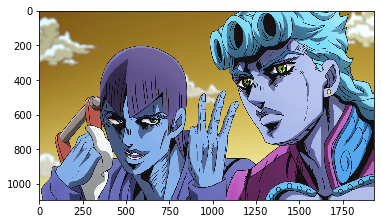

In [251]:
for i in range(100):
    reshi,reslo = readFrame(cap)


INFO:tensorflow:Restoring parameters from models\final.ckpt


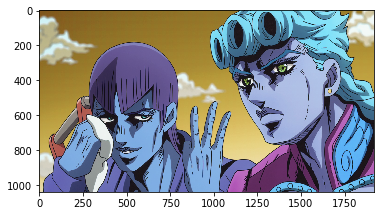

In [252]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, checkpoint_prefix)
    for i in range(0,1):
        reshi,reslo = readFrame(cap)
        generateSave(reslo,reshi)